# Регрессия SVM

Признаки (столбцы):  
Возраст - __Age__ : Возраст застрахованного лица (числовой)  
Пол - __Gender__ : Пол застрахованного лица (Категория: Мужской, Женский)  
Годовой доход - __Annual Income__ : Годовой доход застрахованного лица (числовой, асимметричный)  
Семейное положение - __Marital Status__ : Семейное положение застрахованного лица (категория: холост, женат, разведен)  
Количество иждивенцев - __Number of Dependents__ : Количество иждивенцев (числовое, с пропущенными значениями)  
Уровень образования - __Education Level__ : наивысший достигнутый уровень образования (категория: средняя школа, бакалавр, магистр, доктор философии)  
Род занятий - __Occupation__ : Род занятий застрахованного лица (категория: работающий по найму, самозанятый, безработный)  
Оценка состояния здоровья - __Health Score__ : оценка, отражающая состояние здоровья (числовая, асимметричная)  
Местоположение - __Location__ : Тип местоположения (Категория: Город, Пригород, Сельская местность)  
Тип полиса - __Policy Type__ : Тип страхового полиса (Категорийный: Базовый, Комплексный, Премиум)  
Предыдущие заявления - __Previous Claims__ : Количество предыдущих заявлений (числовое, с выбросами)  
Возраст транспортного средства - __Vehicle Age__ : Возраст застрахованного транспортного средства (числовой)  
Кредитный рейтинг - __Credit Score__ : кредитный рейтинг застрахованного лица (числовой, с отсутствующими значениями)  
Срок действия страхового полиса - __Insurance Duration__ : Срок действия страхового полиса (числовой, в годах)  
Дата начала действия полиса - __Policy Start Date__ : Дата начала действия страхового полиса (Текст, неправильно отформатирован)  
Отзывы клиентов - __Customer Feedback__ : краткие отзывы клиентов (текст)  
Статус курения  - __Smoking Status__  : Статус курения застрахованного лица (Категория: Да, Нет)  
Частота упражнений - __Exercise Frequency__ : Частота упражнений (Категория: Ежедневно, Еженедельно, Ежемесячно, Редко)  
Тип недвижимости  - __Property Type__ : Тип собственности (Категория: Дом, Квартира, Кондоминиум)  

Целевая переменная:  
Сумма страховой премии - __Premium Amount__ : целевая переменная, представляющая сумму страховой премии (числовая, асимметричная)  

In [1]:
import time
from glob import glob
import os 
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


from cuml.metrics._ranking import roc_auc_score as cuml_roc_auc_score
from cuml.metrics._ranking import precision_recall_curve
from cuml.metrics.accuracy import accuracy_score  as cuml_accuracy_score
from cuml.metrics.confusion_matrix import confusion_matrix as cuml_confusion_matrix



from sklearn.svm import LinearSVC  # Используем LinearSVC для линейного ядра
from cuml.svm import SVC as cuSVC  # Используем GPU-ускоренную модель SVC
import cudf
import cupy as cp





 
import matplotlib.pyplot as plt  
import pathlib 
import pandas as pd
import numpy as np
from glob import glob
import os 
import seaborn as sns
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_log_error




from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler,  MinMaxScaler
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import LabelEncoder










print('Виртуальное окружение')
!which python 
# Текущее положение
print('\nТекущее положение: ')
path_1 = os.getcwd()
print(path_1)
print("\nДатасет: ")
!ls dataset

Виртуальное окружение
/home/maksim/develops/python/MAKSIM/.venv/bin/python

Текущее положение: 
/home/maksim/develops/python/MAKSIM/ML/5_SVM_regress

Датасет: 
sample_submission.csv  test.csv  train.csv


In [2]:
def cleaning_resource(var_name=None):
    ''' 
        Очистка памяти для указанной переменной
    '''
    import gc
    import sys
    from pympler import asizeof
    if var_name in globals():  # Проверяем, существует ли глобальная переменная
        size1 = asizeof.asizeof(globals()[var_name])  # Измеряем реальный размер
        print(f"Объём переменной: {size1 / (1024**2):.2f} МБ")  # В мегабайтах
        del globals()[var_name]
        print(f"✅ Объект {var_name} удалён")
    elif var_name in locals():  # Проверяем локальную переменную
        size1 = asizeof.asizeof(locals()[var_name])  # Измеряем размер
        print(f"Объём переменной: {size1 / (1024**2):.2f} МБ")  # В мегабайтах
        del locals()[var_name]
        print(f"✅ Локальный объект {var_name} удалён")
    else:
        print(f"⚠️ Переменная {var_name} не найдена, но память очищена")

    gc.collect()  # Очистка памяти


def plot_box_plot(data):
    ''' 
        Построение графиков (ящик с усами)
    '''
    features = data.columns

    num_features = len(features)

    fig, axes = plt.subplots(1, num_features, figsize=(num_features * 3, 10))

    for i, feature in enumerate(features):
        sns.boxplot(y=data[feature], ax=axes[i])
        axes[i].set_title(feature)
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')

    plt.tight_layout()
    plt.show()



def plot_histogram(data):
    ''' 
        Построение гарфиков  гистограм
    '''
    features = data.columns

    num_features = len(features)
    num_rows = (num_features + 1) // 2  

    fig, axes = plt.subplots(num_rows, 2, figsize=(14, num_rows * 4))
    axes = axes.flatten() 

    for i, feature in enumerate(features):
        sns.histplot(data[feature], kde=True, ax=axes[i])
        axes[i].set_title(f'Распределение признака "{feature}"')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Frequency')

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


def plot_histogram_box(data, col='Premium Amount'):
    ''' 
        Функция построения графиков попарно, гистограмма и Ящик с усами
    '''
    # Создаем два графика в одной строке (1 строка, 2 столбца)
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))  

    # Гистограмма
    sns.histplot(data[col], bins=30, kde=True, ax=axes[0])
    axes[0].set_title(f'Гистограмма {col}')
    axes[0].set_xlabel(f'{col}')
    axes[0].set_ylabel('Частота')

    # Boxplot (ящик с усами)
    sns.boxplot(x=data[col], ax=axes[1])
    axes[1].set_title(f'Ящик с усами  {col}')
    axes[1].set_xlabel(f'{col}')

    # Показываем оба графика в одном окне
    plt.tight_layout()
    plt.show()
    
    
def plot_histogram_chart(data, col=''):
    ''' 
        Функция построения графиков попарно, гистограмма и круговой
    '''
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))  

    # Гистограмма (countplot)
    sns.countplot(x=data[col], ax=axes[0])
    axes[0].set_title(f'Гистограмма {col}')
    axes[0].set_xlabel(col)
    axes[0].set_ylabel('Частота')
    axes[0].tick_params(axis='x', rotation=45)  

    # Pie chart (круговая диаграмма)
    data[col].value_counts().plot.pie(ax=axes[1], autopct='%1.1f%%', startangle=90, cmap='Set3')
    axes[1].set_title(f'Распределение категорий в {col}')
    axes[1].set_ylabel('')  
    # Выводим оба графика
    plt.tight_layout()
    plt.show()
    
    

def plot_analize_data(data1, num_col_del):
    ''' 
        Строит в цикле попарно графики для числовых и категориальных столбцов
    '''
    data = data1.drop(columns=num_col_del, errors='ignore')  
    numeric_columns = data.select_dtypes(include=[np.number])  # Выбираем числовые столбцы

    for col in numeric_columns.columns:
        plot_histogram_box(data, col)
        
        
    categorical_columns = data.select_dtypes(exclude=[np.number])
    

    # Визуализация категориальных признаков
    for col in categorical_columns.columns:
        plot_histogram_chart(data, col)
        
  

def analiz_data(data):
    ''' 
        Анализ данных
    '''
    # Выбираем только числовые столбцы
    numeric_columns = data.select_dtypes(include=[np.number])
    eda_results = pd.DataFrame({
    "Доля пропусков (%)": numeric_columns.isnull().mean() * 100,
    "Максимальное значение": numeric_columns.max(),
    "Минимальное значение": numeric_columns.min(),
    "Среднее значение": numeric_columns.mean(),
    "Медиана": numeric_columns.median(),
    "Дисперсия": numeric_columns.var(),
    "Квантиль 0.1": numeric_columns.quantile(0.1),
    "Квантиль 0.9": numeric_columns.quantile(0.9),
    "Квартиль 1 (25%)": numeric_columns.quantile(0.25),
    "Квартиль 3 (75%)": numeric_columns.quantile(0.75)
    })

    # Выбираем только категориальные столбцы
    categorical_columns = data.select_dtypes(exclude=[np.number])
    # Рассчитываем статистики
    eda_categorical = pd.DataFrame({
        "Доля пропусков (%)": categorical_columns.isnull().mean() * 100,
        "Количество уникальных значений": categorical_columns.nunique(),
        "Наиболее частое значение (мода)": categorical_columns.mode().iloc[0],
        "Частота моды (%)": categorical_columns.apply(lambda x: x.value_counts(normalize=True).iloc[0] * 100)
    })

    # Выводим результаты
    print("Числовые признаки: \n")
    print(eda_results.to_string())
    print("\nКатегориальные признаки: \n")
    print(eda_categorical.to_string())
    
    return numeric_columns, categorical_columns



    

def encode_categorical_features(data):
    """
    Кодирует категориальные признаки:
    - Label Encoding для порядковых категорий (Education Level, Exercise Frequency, Policy Type, Location, Occupation)
    - One-Hot Encoding для номинальных категорий (Gender, Marital Status, Smoking Status)
    """

    # 1. Определяем категории
    ordinal_features = ["Education Level", "Exercise Frequency", "Policy Type", "Location", "Occupation"]  # Порядковые категории
    nominal_features = ["Gender", "Marital Status", "Smoking Status"]  # Номинальные категории

    # 2. Кодируем 'Policy Type' вручную
    policy_mapping = {"Basic": 0, "Comprehensive": 1, "Premium": 2}
    if "Policy Type" in data.columns:
        data["Policy Type"] = data["Policy Type"].map(policy_mapping)
        print("Столбец 'Policy Type' закодирован как:", policy_mapping)

    # 3. Кодируем 'Location' вручную
    location_mapping = {"Rural": 0, "Suburban": 1, "Urban": 2}
    if "Location" in data.columns:
        data["Location"] = data["Location"].map(location_mapping)
        print("Столбец 'Location' закодирован как:", location_mapping)

    # 4. Кодируем 'Occupation' вручную
    occupation_mapping = {"Unemployed": 0, "Self-Employed": 1, "Employed": 2}
    if "Occupation" in data.columns:
        data["Occupation"] = data["Occupation"].map(occupation_mapping)
        print("Столбец 'Occupation' закодирован как:", occupation_mapping)

    # 5. Label Encoding для остальных порядковых переменных
    label_encoders = {}
    for col in ordinal_features:
        if col in data.columns and col not in ["Policy Type", "Location", "Occupation"]:  # Эти уже закодированы вручную
            le = LabelEncoder()
            data[col] = le.fit_transform(data[col])
            label_encoders[col] = le  # Сохраняем энкодер (для обратного преобразования)

    # 6. One-Hot Encoding для номинальных переменных
    data = pd.get_dummies(data, columns=nominal_features, drop_first=True)  # drop_first=True уменьшает размерность

    return data, label_encoders


def handle_missing_values(data, threshold=35):
    """
    Обрабатывает пропущенные значения:
    - Удаляет столбцы, если пропусков > threshold%
    - 'Number of Dependents' → 0
    - 'Credit Score' → среднее значение
    - 'Property Type' → 'Apartment' (самая частая категория)
    - 'Property Type' → Кодируем: Apartment=0, Condo=1, House=2
    - Остальные числовые столбцы → медиана
    - Категориальные столбцы → мода
    """

    # Создаём копию, чтобы не менять оригинальные данные
    data = data.copy()

    # 1. Считаем процент пропусков в каждом столбце
    missing_percent = data.isnull().mean() * 100

    # 2. Удаляем столбцы, если пропусков > threshold%
    cols_to_drop = list(missing_percent[missing_percent > threshold].index)
    data.drop(columns=cols_to_drop, inplace=True)
    print(f"Удалены столбцы с более чем {threshold}% пропусков: {cols_to_drop}\n")

    # 3. Заполняем пропуски в "Number of Dependents" значением 0
    if "Number of Dependents" in data.columns:
        data["Number of Dependents"] = data["Number of Dependents"].fillna(0)
        print("Пропуски в 'Number of Dependents' заменены на 0.\n")

    # 4. Заполняем пропуски в "Credit Score" средним значением
    if "Credit Score" in data.columns:
        mean_credit_score = data["Credit Score"].mean()
        data["Credit Score"] = data["Credit Score"].fillna(mean_credit_score)
        print(f"Пропуски в 'Credit Score' заменены на среднее: {mean_credit_score:.2f}\n")

    # 5. Заполняем пропуски в "Property Type"
    if "Property Type" in data.columns:
        data["Property Type"] = data["Property Type"].fillna("House")
        print("Пропуски в 'Property Type' заменены на 'House'.\n")

        # Кодируем 'Property Type' в порядке возрастания
        property_mapping = {"Apartment": 0, "Condo": 1, "House": 2}
        data["Property Type"] = data["Property Type"].map(property_mapping)
        print("Столбец 'Property Type' закодирован: Apartment=0, Condo=1, House=2.\n")

    # 6. Заполняем оставшиеся числовые столбцы медианой
    numeric_columns = data.select_dtypes(include=[np.number]).drop(
        columns=["Number of Dependents", "Credit Score"], errors="ignore"
    )
    data[numeric_columns.columns] = numeric_columns.fillna(numeric_columns.median())

    # 7. Заполняем остальные категориальные столбцы модой
    categorical_columns = data.select_dtypes(exclude=[np.number])
    for col in categorical_columns.columns:
        data[col] = data[col].fillna(data[col].mode().iloc[0])

    return data

   
    
def normalize_data(data, method="standard"):
    """
    Нормализует числовые данные.
    method="standard" → StandardScaler (приводит к среднему 0 и std=1)
    method="minmax" → MinMaxScaler (масштабирует от 0 до 1)
    """

    numeric_columns = data.select_dtypes(include=[np.number]).columns  # Только числовые столбцы
    scaler = StandardScaler() if method == "standard" else MinMaxScaler()

    # Применяем масштабирование только к числовым столбцам
    data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

    return data
    
def evaluate_model(model, X_val, y_val):
    y_pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)
    rmse = mse ** 0.5
    rmsle_poly = root_mean_squared_log_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    return {"MAE": mae, "MSE": mse, "RMSE": rmse, "RMSLE": rmsle_poly, "R²": r2}

## 1) Загрузка данных

In [3]:
train_df = pd.read_csv('dataset/train.csv')


train_df = train_df.drop(columns=["id"])

# test_df = pd.read_csv('dataset/test.csv')
# test_df = test_df.drop(columns=["id"])



print('\nРазмер данных: ', train_df.shape)

print(train_df.head().to_string(index=False))

X = train_df.drop(columns=['Premium Amount'])
y = train_df['Premium Amount']
print("\nПропуски:")
train_df.isnull().sum()


Размер данных:  (1200000, 20)
 Age Gender  Annual Income Marital Status  Number of Dependents Education Level    Occupation  Health Score Location   Policy Type  Previous Claims  Vehicle Age  Credit Score  Insurance Duration          Policy Start Date Customer Feedback Smoking Status Exercise Frequency Property Type  Premium Amount
19.0 Female        10049.0        Married                   1.0      Bachelor's Self-Employed     22.598761    Urban       Premium              2.0         17.0         372.0                 5.0 2023-12-23 15:21:39.134960              Poor             No             Weekly         House          2869.0
39.0 Female        31678.0       Divorced                   3.0        Master's           NaN     15.569731    Rural Comprehensive              1.0         12.0         694.0                 2.0 2023-06-12 15:21:39.111551           Average            Yes            Monthly         House          1483.0
23.0   Male        25602.0       Divorced                

Age                      18705
Gender                       0
Annual Income            44949
Marital Status           18529
Number of Dependents    109672
Education Level              0
Occupation              358075
Health Score             74076
Location                     0
Policy Type                  0
Previous Claims         364029
Vehicle Age                  6
Credit Score            137882
Insurance Duration           1
Policy Start Date            0
Customer Feedback        77824
Smoking Status               0
Exercise Frequency           0
Property Type                0
Premium Amount               0
dtype: int64

## 2) Анализ

In [4]:
# Оставляем только числовые столбцы
numeric_data = train_df.select_dtypes(include=[np.number])

# Вычисляем статистики
statistics = {
    "Доля пропусков": train_df.isnull().mean(),
    "Максимум": numeric_data.max(),
    "Минимум": numeric_data.min(),
    "Среднее": numeric_data.mean(),
    "Медиана": numeric_data.median(),
    "Дисперсия": numeric_data.var(),
    "Квантиль 0.1": numeric_data.quantile(0.1),
    "Квантиль 0.9": numeric_data.quantile(0.9),
    "Квартиль 1": numeric_data.quantile(0.25),
    "Квартиль 3": numeric_data.quantile(0.75),
}

statistics_df = pd.DataFrame(statistics)
print(statistics_df.to_string())

                      Доля пропусков       Максимум     Минимум       Среднее       Медиана     Дисперсия  Квантиль 0.1  Квантиль 0.9   Квартиль 1    Квартиль 3
Age                     1.558750e-02      64.000000   18.000000     41.145563     41.000000  1.833302e+02     22.000000     60.000000    30.000000     53.000000
Annual Income           3.745750e-02  149997.000000    1.000000  32745.217777  23911.000000  1.035521e+09   2627.000000  81075.000000  8001.000000  44634.000000
Credit Score            1.149017e-01     849.000000  300.000000    592.924350    595.000000  2.249458e+04    383.000000    792.000000   468.000000    721.000000
Customer Feedback       6.485333e-02            NaN         NaN           NaN           NaN           NaN           NaN           NaN          NaN           NaN
Education Level         0.000000e+00            NaN         NaN           NaN           NaN           NaN           NaN           NaN          NaN           NaN
Exercise Frequency      0.000000e+

In [5]:
numeric_columns, categorical_columns = analiz_data(train_df)

Числовые признаки: 

                      Доля пропусков (%)  Максимальное значение  Минимальное значение  Среднее значение       Медиана     Дисперсия  Квантиль 0.1  Квантиль 0.9  Квартиль 1 (25%)  Квартиль 3 (75%)
Age                             1.558750              64.000000             18.000000         41.145563     41.000000  1.833302e+02     22.000000     60.000000         30.000000         53.000000
Annual Income                   3.745750          149997.000000              1.000000      32745.217777  23911.000000  1.035521e+09   2627.000000  81075.000000       8001.000000      44634.000000
Number of Dependents            9.139333               4.000000              0.000000          2.009934      2.000000  2.008846e+00      0.000000      4.000000          1.000000          3.000000
Health Score                    6.173000              58.975914              2.012237         25.613908     24.578648  1.489245e+02      9.936849     43.281339         15.918959         34.527209

## 3) Подготовка датасета

#### Удаление пропусков

In [6]:
# Очистка от пропусков 
train_data_cleaned = handle_missing_values(train_df)
num_col_del = ['id']

Удалены столбцы с более чем 35% пропусков: []

Пропуски в 'Number of Dependents' заменены на 0.

Пропуски в 'Credit Score' заменены на среднее: 592.92

Пропуски в 'Property Type' заменены на 'House'.

Столбец 'Property Type' закодирован: Apartment=0, Condo=1, House=2.



In [7]:
# Проверим отсутсвие пропусков
numeric_columns, categorical_columns = analiz_data(train_data_cleaned)

Числовые признаки: 

                      Доля пропусков (%)  Максимальное значение  Минимальное значение  Среднее значение       Медиана     Дисперсия  Квантиль 0.1  Квантиль 0.9  Квартиль 1 (25%)  Квартиль 3 (75%)
Age                                  0.0              64.000000             18.000000         41.143294     41.000000  1.804729e+02     22.000000     60.000000         30.000000          53.00000
Annual Income                        0.0          149997.000000              1.000000      32414.310064  23911.000000  9.995464e+08   2699.000000  79448.100000       8646.000000       43936.00000
Number of Dependents                 0.0               4.000000              0.000000          1.826239      2.000000  2.160721e+00      0.000000      4.000000          0.000000           3.00000
Health Score                         0.0              58.975914              2.012237         25.550001     24.578648  1.397934e+02     10.185439     42.845833         16.554572          33.77289

In [8]:
# Закодируем категориальные столбцы
train_data_encoded, label_encoders = encode_categorical_features(train_data_cleaned)


print(train_data_encoded.head().to_string())

Столбец 'Policy Type' закодирован как: {'Basic': 0, 'Comprehensive': 1, 'Premium': 2}
Столбец 'Location' закодирован как: {'Rural': 0, 'Suburban': 1, 'Urban': 2}
Столбец 'Occupation' закодирован как: {'Unemployed': 0, 'Self-Employed': 1, 'Employed': 2}
    Age  Annual Income  Number of Dependents  Education Level  Occupation  Health Score  Location  Policy Type  Previous Claims  Vehicle Age  Credit Score  Insurance Duration           Policy Start Date Customer Feedback  Exercise Frequency  Property Type  Premium Amount  Gender_Male  Marital Status_Married  Marital Status_Single  Smoking Status_Yes
0  19.0        10049.0                   1.0                0           1     22.598761         2            2              2.0         17.0     372.00000                 5.0  2023-12-23 15:21:39.134960              Poor                   3              2          2869.0        False                    True                  False               False
1  39.0        31678.0                   3.

In [9]:
train_data_encoded["Policy Start Date"] = pd.to_datetime(train_data_encoded["Policy Start Date"])

# Извлекаем только год
train_data_encoded["Policy Start Date"] = train_data_encoded["Policy Start Date"].dt.year  

# Сортируем список уникальных годов
unique_years = sorted(train_data_encoded["Policy Start Date"].unique())

# Создаём словарь для кодирования годов
year_mapping = {year: idx for idx, year in enumerate(unique_years)}

# Применяем замену
train_data_encoded["Policy Start Date"] = train_data_encoded["Policy Start Date"].map(year_mapping)

# Проверяем результат
print(train_data_encoded[["Policy Start Date"]].head())
print(f"Годы закодированы следующим образом: {year_mapping}")

# Определяем правильный порядок для категорий
feedback_mapping = {
    "Average": 1,
    "Good": 2,
    "Poor": 0
}

# Применяем mapping
train_data_encoded["Customer Feedback"] = train_data_encoded["Customer Feedback"].map(feedback_mapping)

# Проверяем результат
print(train_data_encoded["Customer Feedback"].head())






   Policy Start Date
0                  4
1                  4
2                  4
3                  5
4                  2
Годы закодированы следующим образом: {np.int32(2019): 0, np.int32(2020): 1, np.int32(2021): 2, np.int32(2022): 3, np.int32(2023): 4, np.int32(2024): 5}
0    0
1    1
2    2
3    0
4    0
Name: Customer Feedback, dtype: int64


In [10]:
numeric_columns, categorical_columns = analiz_data(train_data_encoded)

Числовые признаки: 

                      Доля пропусков (%)  Максимальное значение  Минимальное значение  Среднее значение       Медиана     Дисперсия  Квантиль 0.1  Квантиль 0.9  Квартиль 1 (25%)  Квартиль 3 (75%)
Age                                  0.0              64.000000             18.000000         41.143294     41.000000  1.804729e+02     22.000000     60.000000         30.000000          53.00000
Annual Income                        0.0          149997.000000              1.000000      32414.310064  23911.000000  9.995464e+08   2699.000000  79448.100000       8646.000000       43936.00000
Number of Dependents                 0.0               4.000000              0.000000          1.826239      2.000000  2.160721e+00      0.000000      4.000000          0.000000           3.00000
Education Level                      0.0               3.000000              0.000000          1.506332      2.000000  1.261196e+00      0.000000      3.000000          0.000000           3.00000

#### обработка выбросов

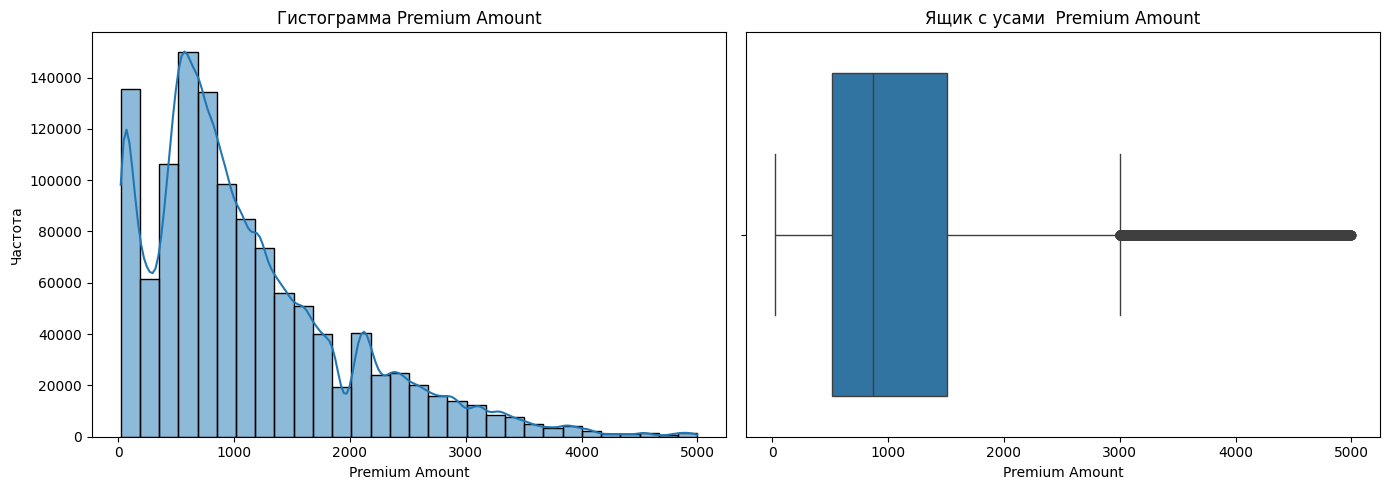

Количество строк после удаления выбросов: 1015992


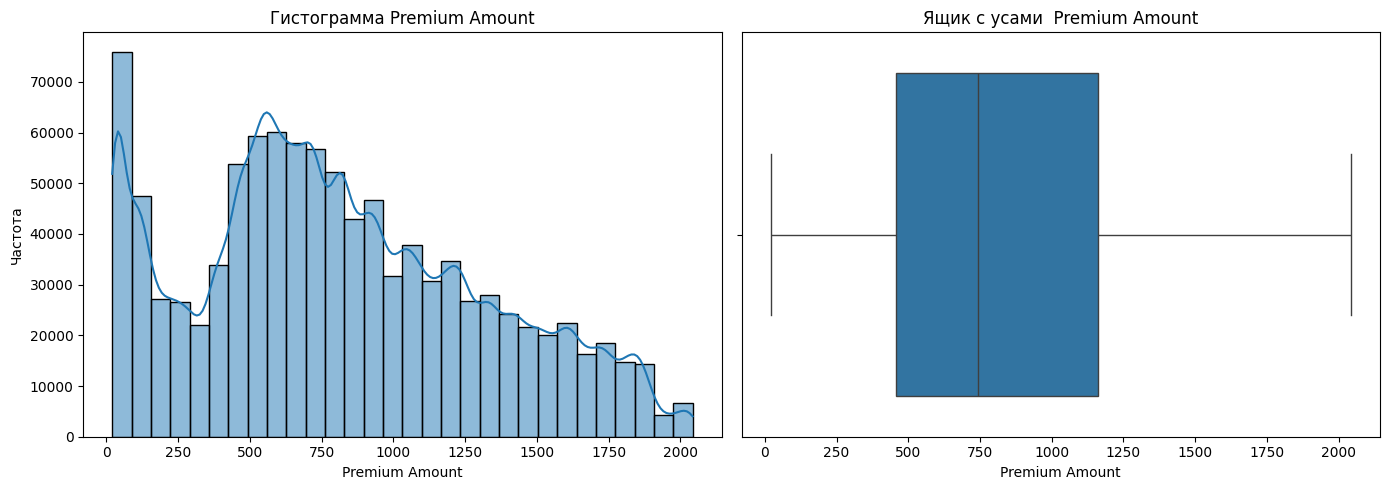

In [11]:
plot_histogram_box(train_data_encoded)

# Находим выбросы в Premium Amount с помощью IQR
Q1 = train_data_encoded["Premium Amount"].quantile(0.35)
Q3 = train_data_encoded["Premium Amount"].quantile(0.65)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Удаляем выбросы
train_data_encoded = train_data_encoded[(train_data_encoded["Premium Amount"] >= lower_bound) & 
                                        (train_data_encoded["Premium Amount"] <= upper_bound)]

# Проверяем размер после удаления выбросов
print(f"Количество строк после удаления выбросов: {train_data_encoded.shape[0]}")

plot_histogram_box(train_data_encoded)



In [12]:
# Проверим выбросы в других числовых столбцах с использованием IQR
for col in numeric_columns.columns:
    Q1 = train_data_encoded[col].quantile(0.25)
    Q3 = train_data_encoded[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.2 * IQR
    
    # Удаляем выбросы
    train_data_encoded = train_data_encoded[(train_data_encoded[col] >= lower_bound) & 
                                             (train_data_encoded[col] <= upper_bound)]
    
    print(f"Обработаны выбросы в столбце {col}.")
    
print(train_data_encoded.shape)

numeric_columns, categorical_columns = analiz_data(train_data_encoded)

Обработаны выбросы в столбце Age.
Обработаны выбросы в столбце Annual Income.
Обработаны выбросы в столбце Number of Dependents.
Обработаны выбросы в столбце Education Level.
Обработаны выбросы в столбце Occupation.
Обработаны выбросы в столбце Health Score.
Обработаны выбросы в столбце Location.
Обработаны выбросы в столбце Policy Type.
Обработаны выбросы в столбце Previous Claims.
Обработаны выбросы в столбце Vehicle Age.
Обработаны выбросы в столбце Credit Score.
Обработаны выбросы в столбце Insurance Duration.
Обработаны выбросы в столбце Policy Start Date.
Обработаны выбросы в столбце Customer Feedback.
Обработаны выбросы в столбце Exercise Frequency.
Обработаны выбросы в столбце Property Type.
Обработаны выбросы в столбце Premium Amount.
(887902, 21)
Числовые признаки: 

                      Доля пропусков (%)  Максимальное значение  Минимальное значение  Среднее значение       Медиана     Дисперсия  Квантиль 0.1  Квантиль 0.9  Квартиль 1 (25%)  Квартиль 3 (75%)
Age             

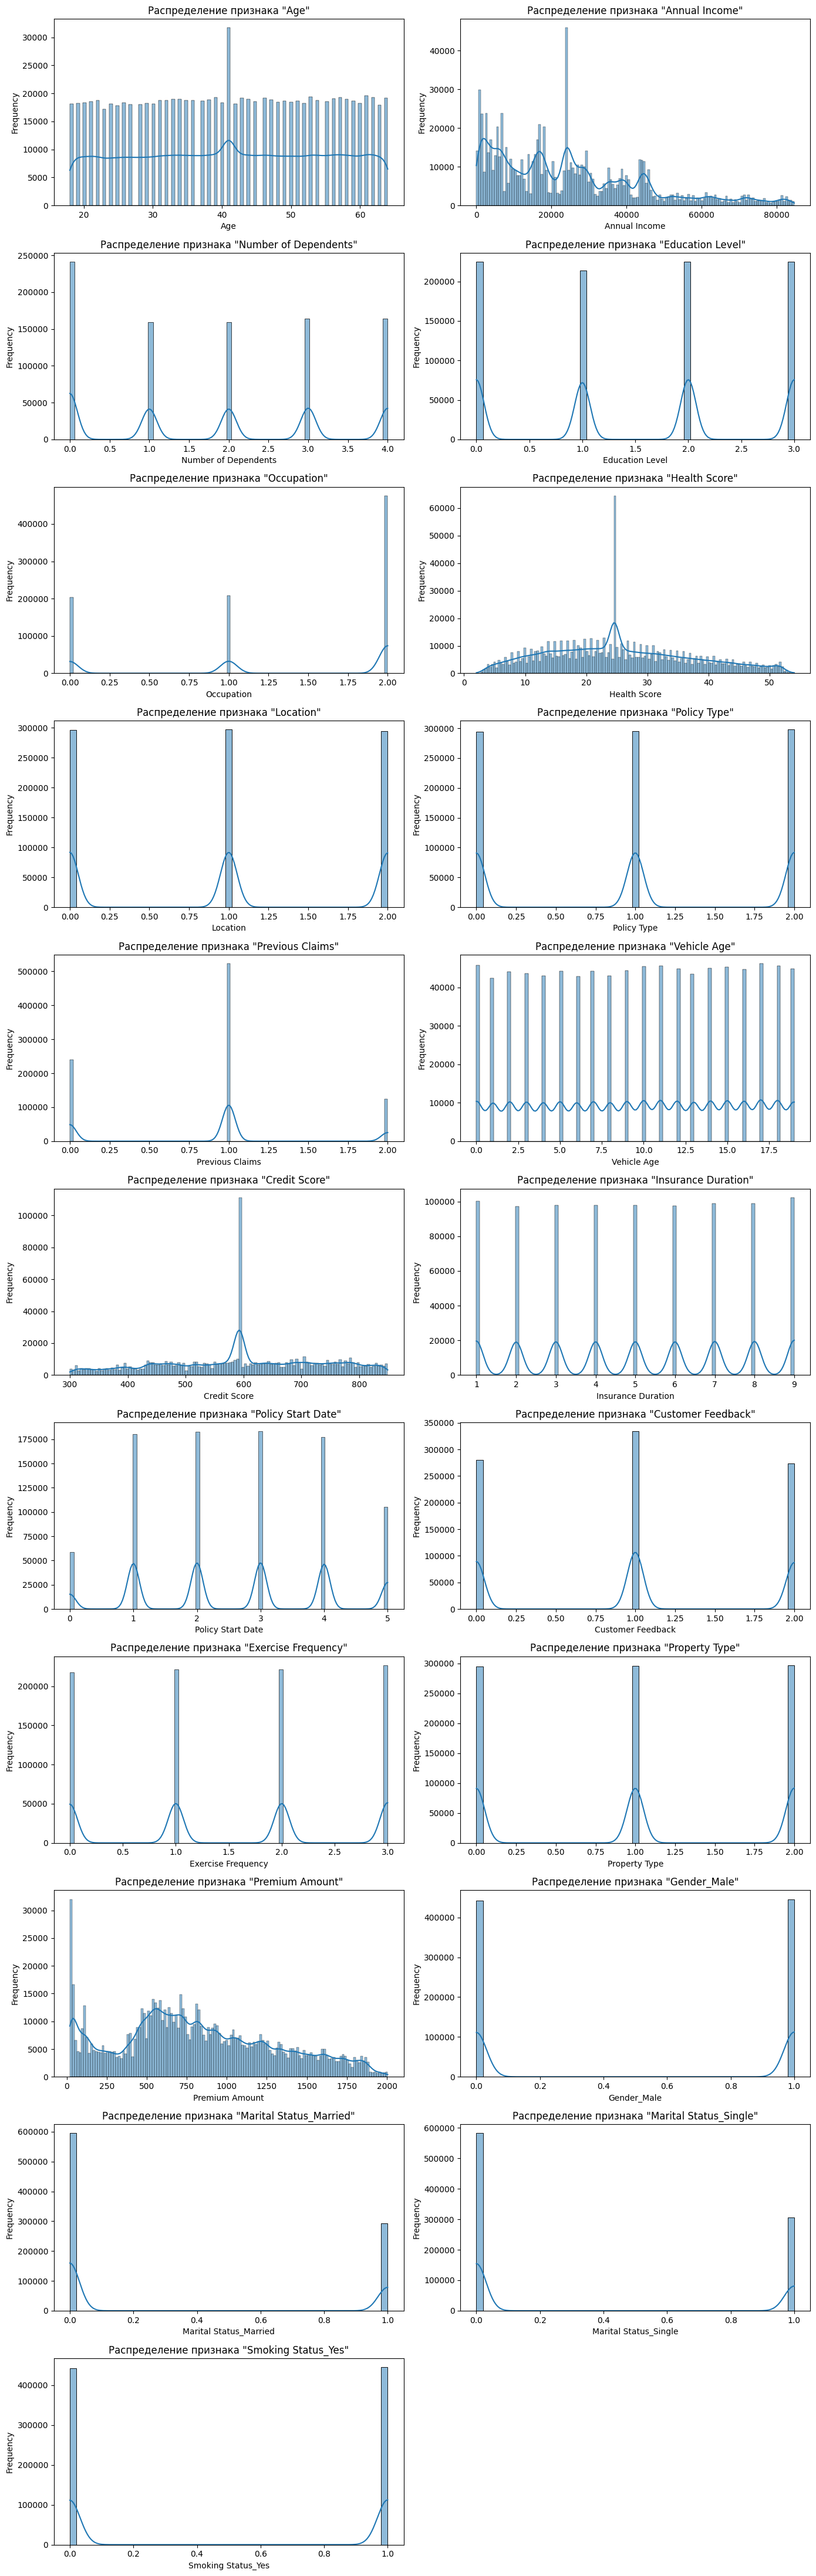

In [13]:

plot_histogram(train_data_encoded)


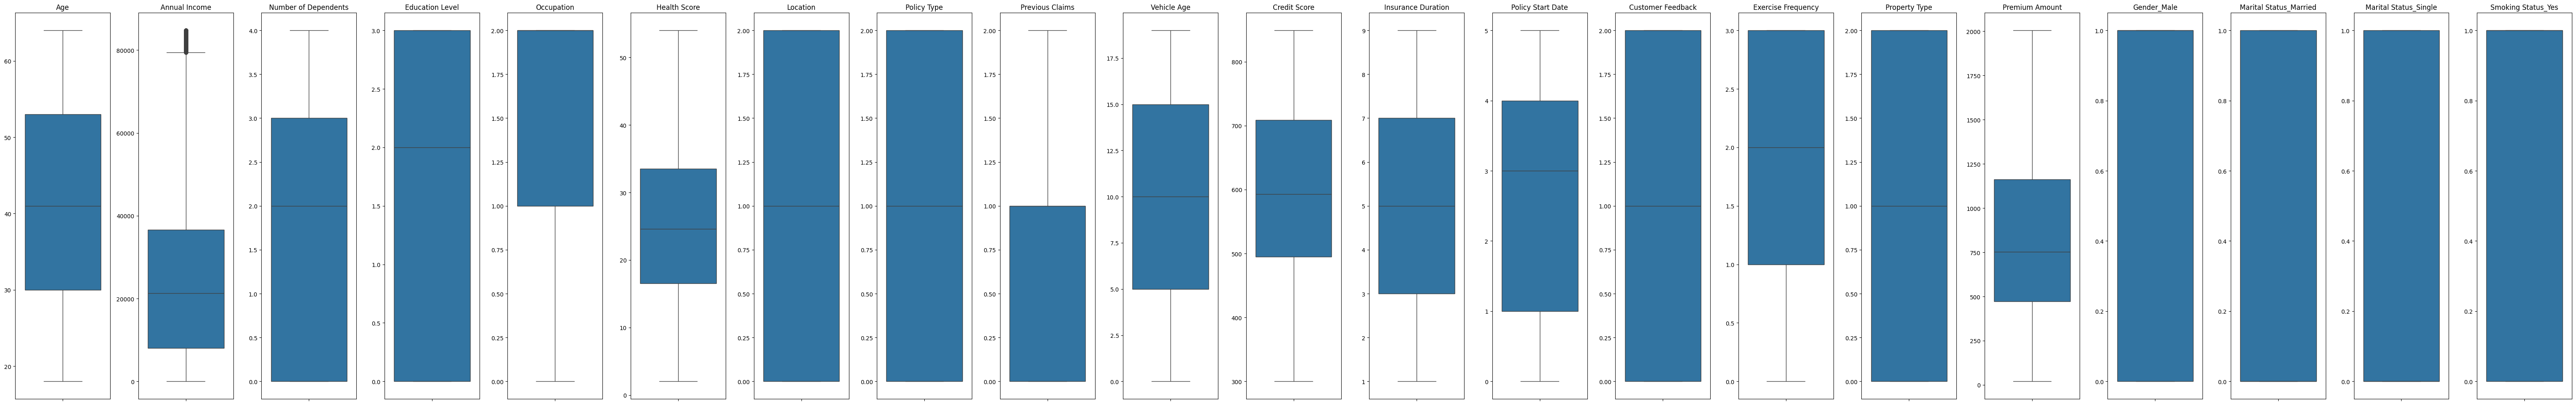

In [14]:
plot_box_plot(train_data_encoded)

#### сбалансируем данные

In [15]:
train_data_encoded["Premium Amount"] = np.cbrt(train_data_encoded["Premium Amount"])
train_data_encoded["Annual Income"] = np.cbrt(train_data_encoded["Annual Income"])

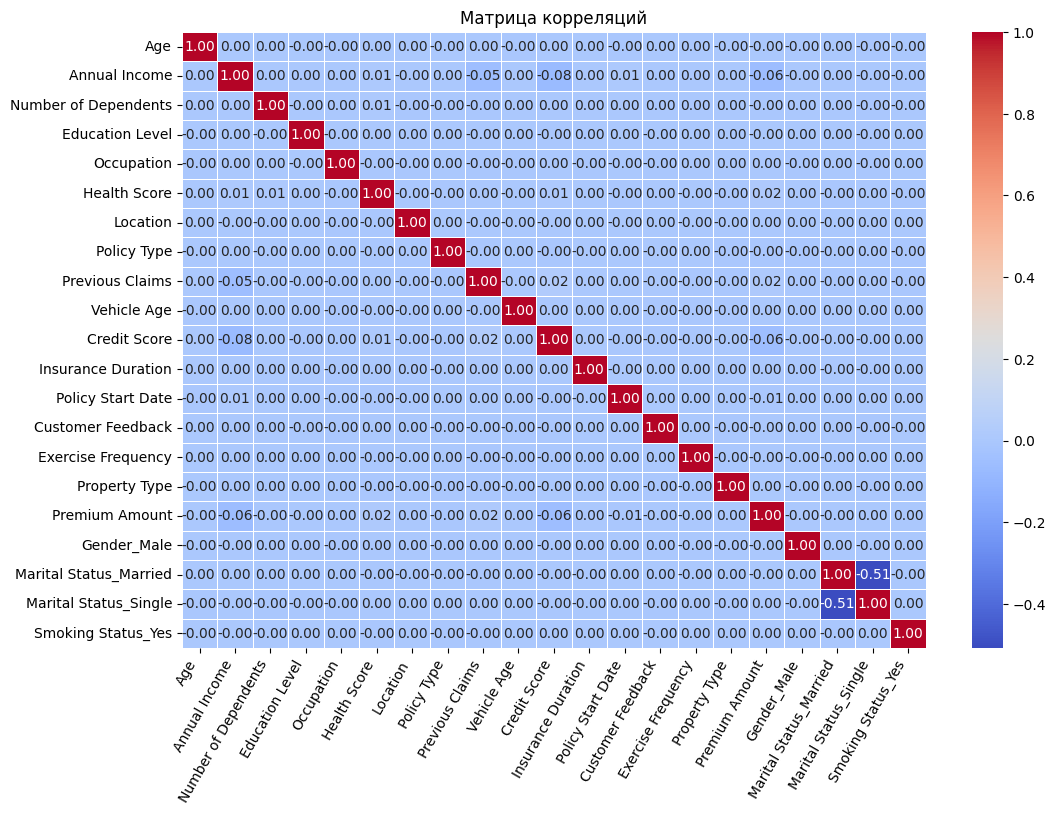

Annual Income            -0.063535
Credit Score             -0.057731
Policy Start Date        -0.006197
Number of Dependents     -0.002029
Policy Type              -0.001154
Gender_Male              -0.000818
Age                      -0.000786
Customer Feedback        -0.000621
Education Level          -0.000349
Marital Status_Married   -0.000320
Exercise Frequency       -0.000013
Vehicle Age               0.000726
Smoking Status_Yes        0.001591
Insurance Duration        0.001622
Location                  0.002002
Occupation                0.002006
Property Type             0.002756
Marital Status_Single     0.002865
Health Score              0.015693
Previous Claims           0.016310
Premium Amount            1.000000
Name: Premium Amount, dtype: float64


In [16]:
# Корреляция
corr_matrix = train_data_encoded.corr()

# Визуализируем корреляционную матрицу
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Матрица корреляций")
plt.xticks(rotation=60, ha='right')  
plt.yticks(rotation=0) 
plt.show()


# Выбираем корреляцию с целевой переменной
target_corr = corr_matrix["Premium Amount"].sort_values(ascending=True)

# Выводим признаки, которые наиболее связаны с Premium Amount
print(target_corr)

## 4) Обучение

In [17]:
import numpy as np
import cupy as cp
import cudf
import time
from cuml.svm import SVR as cuSVR
from cuml.neighbors import KNeighborsRegressor as cuKNN
from cuml.preprocessing import StandardScaler, MinMaxScaler
from cuml.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_squared_log_error
from sklearn.model_selection import train_test_split


def rmsle1(y_true, y_pred):
    return np.sqrt(mean_squared_error(np.log1p(y_true), np.log1p(y_pred)))


def metrics(y_val, y_pred):
    mae = mean_absolute_error(y_val, y_pred)
    mse= mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    rmse = mse ** 0.5 
    # rmsle = mean_squared_log_error(y_val, y_pred)
    rmsle = rmsle1(y_val, y_pred)
    
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"RMSLE: {rmsle:.4f}")
    print(f"R² Score: {r2:.4f}")


In [50]:
selected_features = target_corr[abs(target_corr) > 0.01].index.tolist()
selected_features.remove("Premium Amount")  # Исключаем целевую переменную


X = train_data_encoded[selected_features]
y = train_data_encoded["Premium Amount"]

print(f"Выбранные признаки: {selected_features}")

# Разделяем данные
X_train1, X_val, y_train1, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Размер обучающей выборки: {X_train1.shape}")
print(f"Размер тестовой выборки:  {X_val.shape}")

X_train, _, y_train, _ = train_test_split(
    X_train1, y_train1, test_size=0.001, random_state=42
)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки:  {X_val.shape}")


# Переводим данные в формат cudf (работает на GPU)
X_train_gpu = cudf.DataFrame(X_train)
X_val_gpu = cudf.DataFrame(X_val)
y_train_gpu = cudf.Series(y_train)
y_val_gpu = cudf.Series(y_val)

# Масштабирование данных (на GPU)
scaler = MinMaxScaler()
X_train_scaled_gpu = scaler.fit_transform(X_train_gpu)
X_val_scaled_gpu = scaler.transform(X_val_gpu)

Выбранные признаки: ['Annual Income', 'Credit Score', 'Health Score', 'Previous Claims']
Размер обучающей выборки: (710321, 4)
Размер тестовой выборки:  (177581, 4)
Размер обучающей выборки: (709610, 4)
Размер тестовой выборки:  (177581, 4)


### Обучение KNN на GPU

In [19]:
# === KNN (на GPU) ===
knn_model = cuKNN(n_neighbors=155)
start_time = time.time()
knn_model.fit(X_train_scaled_gpu, y_train_gpu)
knn_time = time.time() - start_time

# Предсказания KNN
y_pred_knn = knn_model.predict(X_val_scaled_gpu)
print(f"Время обучения KNN на GPU : {knn_time:.4f} sec")


metrics(y_val_gpu, y_pred_knn)


Время обучения KNN на GPU : 0.0092 sec
MAE: 1.6794
MSE: 4.8611
RMSE: 2.2048
RMSLE: 0.2755
R² Score: 0.1057


### Обучение на неполных данных для скорости обучения

#### Обучение KNN на GPU  на неполных данных

In [51]:
selected_features = target_corr[abs(target_corr) > 0.01].index.tolist()
selected_features.remove("Premium Amount")  # Исключаем целевую переменную


X = train_data_encoded[selected_features]
y = train_data_encoded["Premium Amount"]

print(f"Выбранные признаки: {selected_features}")

# Разделяем данные
X_train1, X_val, y_train1, y_val = train_test_split(X, y, test_size=0.2)

print(f"Размер обучающей выборки: {X_train1.shape}")
print(f"Размер тестовой выборки:  {X_val.shape}")

X_train, _, y_train, _ = train_test_split(X_train1, y_train1, test_size=0.75)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки:  {X_val.shape}")


# Переводим данные в формат cudf (работает на GPU)
X_train_gpu = cudf.DataFrame(X_train)
X_val_gpu = cudf.DataFrame(X_val)
y_train_gpu = cudf.Series(y_train)
y_val_gpu = cudf.Series(y_val)

# Масштабирование данных (на GPU)
scaler = MinMaxScaler()
X_train_scaled_gpu = scaler.fit_transform(X_train_gpu)
X_val_scaled_gpu = scaler.transform(X_val_gpu)

Выбранные признаки: ['Annual Income', 'Credit Score', 'Health Score', 'Previous Claims']
Размер обучающей выборки: (710321, 4)
Размер тестовой выборки:  (177581, 4)
Размер обучающей выборки: (177580, 4)
Размер тестовой выборки:  (177581, 4)


In [21]:
type(X_train)

pandas.core.frame.DataFrame

In [22]:
type(X_train_gpu)


cudf.core.dataframe.DataFrame

In [36]:
# === KNN (на GPU) ===
knn_model = cuKNN(n_neighbors=155)
start_time = time.time()
knn_model.fit(X_train_scaled_gpu, y_train_gpu)
knn_time = time.time() - start_time

# Предсказания KNN
y_pred_knn = knn_model.predict(X_val_scaled_gpu)
print(f"Время обучения KNN на GPU : {knn_time:.4f} sec")


metrics(y_val_gpu, y_pred_knn)

Время обучения KNN на GPU : 0.0048 sec
MAE: 1.6922
MSE: 4.9248
RMSE: 2.2192
RMSLE: 0.2776
R² Score: 0.1026


In [39]:
# Обучение модели SVR
svr_model = cuSVR(kernel='rbf', C=1.0, epsilon=0.1, max_iter=10000, tol=1e-3)
start_time = time.time()
svr_model.fit(X_train_scaled_gpu, y_train_gpu)
svr_time = time.time() - start_time
print(f"Время обучения cuSVR на GPU : {svr_time:.4f} sec")
# Предсказания SVR
y_pred_svr = svr_model.predict(X_val_scaled_gpu)

metrics(y_val_gpu, y_pred_svr)

Время обучения cuSVR на GPU : 390.9585 sec
MAE: 3.0166
MSE: 13.6263
RMSE: 3.6914
RMSLE: nan
R² Score: -1.5005


#### Для сравнения: время обучения SVR на CPU и GPU

In [57]:
# Обучение модели SVR
svr_model = cuSVR(kernel='rbf', C=1.0, epsilon=0.1, max_iter=1000, tol=1e-3)
start_time = time.time()
svr_model.fit(X_train_scaled_gpu, y_train_gpu)
svr_time = time.time() - start_time
print(f"Время обучения cuSVR на GPU : {svr_time:.4f} sec")
# Предсказания SVR
y_pred_svr = svr_model.predict(X_val_scaled_gpu)

metrics(y_val_gpu, y_pred_svr)

Время обучения cuSVR на GPU : 46.3956 sec
MAE: 3.5770
MSE: 20.3735
RMSE: 4.5137
RMSLE: 0.4450
R² Score: -2.7297


In [58]:
# Обучение модели SVR
svr_model = cuSVR(kernel='rbf', C=0.1, epsilon=0.1, gamma=0.01, max_iter=30000)
start_time = time.time()
svr_model.fit(X_train_scaled_gpu, y_train_gpu)
svr_time = time.time() - start_time
print(f"Время обучения cuSVR на GPU : {svr_time:.4f} sec")
# Предсказания SVR
y_pred_svr = svr_model.predict(X_val_scaled_gpu)

metrics(y_val_gpu, y_pred_svr)

Время обучения cuSVR на GPU : 14.7547 sec
MAE: 1.7844
MSE: 5.5314
RMSE: 2.3519
RMSLE: 0.2968
R² Score: -0.0126


In [59]:
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score




# Масштабируем данные, так как SVR и KNN чувствительны к разным шкалам признаков
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


# Обучение модели SVR
svr_model = SVR(kernel='rbf', C=0.1, epsilon=0.1, gamma=0.01, max_iter=30000)
start_time = time.time()
svr_model.fit(X_train_scaled, y_train)
svr_time_cpu = time.time() - start_time
print("Сравнение времени обучения")
print(f"Время обучения на GPU: {svr_time:.4f} sec")
print(f"Время обучения на CPU: {svr_time_cpu:.4f} sec")


# Предсказания SVR
y_pred_svr = svr_model.predict(X_val_scaled)

# Метрики SVR
mae_svr = mean_absolute_error(y_val, y_pred_svr)
mse_svr = mean_squared_error(y_val, y_pred_svr)
r2_svr = r2_score(y_val, y_pred_svr)


# Вывод результатов
print("\nSVR Результаты:")
print(f"MAE: {mae_svr:.4f}")
print(f"MSE: {mse_svr:.4f}")
print(f"R² Score: {r2_svr:.4f}\n")


/home/maksim/develops/python/MAKSIM/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=30000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Сравнение времени обучения
Время обучения на GPU: 14.7547 sec
Время обучения на CPU: 208.0602 sec

SVR Результаты:
MAE: 2.6809
MSE: 9.1708
R² Score: -0.6788



#### Разница времени обучения - на GPU обучение намного быстрее
Время обучения на GPU: 14.7547 sec  
Время обучения на CPU: 208.0602 sec  

## 5) Сравнение  
Время обучения KNN на GPU : 0.0048 sec  
MAE: 1.6922  
MSE: 4.9248  
RMSE: 2.2192  
RMSLE: 0.2776  
R² Score: 0.1026     

Время обучения cuSVR на GPU : 390.9585 sec  
MAE: 3.0166  
MSE: 13.6263  
RMSE: 3.6914  
RMSLE: nan  
R² Score: -1.5005   
#### Лучший результат у KNN

## 6) Подбор параметров

In [18]:
import numpy as np
import cupy as cp
import cudf
import time
from cuml.svm import SVR as cuSVR
from cuml.neighbors import KNeighborsRegressor as cuKNN
from cuml.preprocessing import StandardScaler, MinMaxScaler
from cuml.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_squared_log_error
from sklearn.model_selection import train_test_split


def rmsle1(y_true, y_pred):
    return np.sqrt(mean_squared_error(np.log1p(y_true), np.log1p(y_pred)))


def metrics(y_val, y_pred):
    mae = mean_absolute_error(y_val, y_pred)
    mse= mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    rmse = mse ** 0.5 
    # rmsle = mean_squared_log_error(y_val, y_pred)
    rmsle = rmsle1(y_val, y_pred)
    
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"RMSLE: {rmsle:.4f}")
    print(f"R² Score: {r2:.4f}")
    
selected_features = target_corr[abs(target_corr) > 0.01].index.tolist()
    
selected_features.remove("Premium Amount")  # Исключаем целевую переменную


X = train_data_encoded[selected_features]
y = train_data_encoded["Premium Amount"]

print(f"Выбранные признаки: {selected_features}")

# Разделяем данные
X_train1, X_val, y_train1, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Размер обучающей выборки: {X_train1.shape}")
print(f"Размер тестовой выборки:  {X_val.shape}")

X_train, _, y_train, _ = train_test_split(
    X_train1, y_train1, test_size=0.75, random_state=42
)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки:  {X_val.shape}")


# Переводим данные в формат cudf (работает на GPU)
X_train_gpu = cudf.DataFrame(X_train)
X_val_gpu = cudf.DataFrame(X_val)
y_train_gpu = cudf.Series(y_train)
y_val_gpu = cudf.Series(y_val)

# Масштабирование данных (на GPU)
scaler = MinMaxScaler()
X_train_scaled_gpu = scaler.fit_transform(X_train_gpu)
X_val_scaled_gpu = scaler.transform(X_val_gpu)

Выбранные признаки: ['Annual Income', 'Credit Score', 'Health Score', 'Previous Claims']
Размер обучающей выборки: (710321, 4)
Размер тестовой выборки:  (177581, 4)
Размер обучающей выборки: (177580, 4)
Размер тестовой выборки:  (177581, 4)


In [19]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [20]:
import time
import pandas as pd
from cuml.svm import SVR as cuSVR
from cuml.metrics import mean_absolute_error, mean_squared_error, r2_score

# Определяем параметры для перебора
C_values = [0.01, 0.1,  1.0]
epsilon_values = [0.01, 0.1, 0.5]
gamma_values = ["scale", "auto", 0.01, 0.1]  # Добавили gamma
kernels = ["rbf"]

# Словарь для хранения результатов
results = []

# Перебираем параметры вручную
for C in C_values:
    for epsilon in epsilon_values:
        for gamma in gamma_values:
            for kernel in kernels:
                print(f"Обучение модели с параметрами: C={C}, epsilon={epsilon}, gamma={gamma}, kernel={kernel}")

                # Инициализируем SVR
                svr = cuSVR(C=C, epsilon=epsilon, gamma=gamma, kernel=kernel)

                # Засекаем время обучения
                start_train = time.time()
                svr.fit(X_train_scaled_gpu, y_train_gpu)
                train_time = time.time() - start_train

                # Засекаем время предсказания
                start_pred = time.time()
                y_pred = svr.predict(X_val_scaled_gpu)
                pred_time = time.time() - start_pred

                # Вычисляем метрики
                mae = mean_absolute_error(y_val_gpu, y_pred)
                mse = mean_squared_error(y_val_gpu, y_pred)
                r2 = r2_score(y_val_gpu, y_pred)

                # Вывод результатов
                print(f"Время обучения: {train_time:.2f} сек | Время предсказания: {pred_time:.2f} сек")
                print(f"MAE: {mae:.4f} | MSE: {mse:.4f} | R²: {r2:.4f}\n")

                # Сохраняем результат
                results.append({
                    "C": C,
                    "epsilon": epsilon,
                    "gamma": gamma,
                    "kernel": kernel,
                    "train_time": train_time,
                    "pred_time": pred_time,
                    "MAE": mae,
                    "MSE": mse,
                    "R2": r2
                })

# Вывод всех результатов в табличном виде
results_df = pd.DataFrame(results)
print(results_df)


Обучение модели с параметрами: C=0.01, epsilon=0.01, gamma=scale, kernel=rbf
Время обучения: 15.53 сек | Время предсказания: 9.31 сек
MAE: 1.7415 | MSE: 5.2823 | R²: 0.0282

Обучение модели с параметрами: C=0.01, epsilon=0.01, gamma=auto, kernel=rbf
Время обучения: 15.05 сек | Время предсказания: 10.29 сек
MAE: 1.7755 | MSE: 5.4742 | R²: -0.0071

Обучение модели с параметрами: C=0.01, epsilon=0.01, gamma=0.01, kernel=rbf
Время обучения: 15.83 сек | Время предсказания: 11.61 сек
MAE: 1.7795 | MSE: 5.5052 | R²: -0.0128

Обучение модели с параметрами: C=0.01, epsilon=0.01, gamma=0.1, kernel=rbf
Время обучения: 15.55 сек | Время предсказания: 10.78 сек
MAE: 1.7786 | MSE: 5.4929 | R²: -0.0105

Обучение модели с параметрами: C=0.01, epsilon=0.1, gamma=scale, kernel=rbf
Время обучения: 15.00 сек | Время предсказания: 9.21 сек
MAE: 1.7419 | MSE: 5.2814 | R²: 0.0284

Обучение модели с параметрами: C=0.01, epsilon=0.1, gamma=auto, kernel=rbf
Время обучения: 14.28 сек | Время предсказания: 9.87 с

In [22]:
# Вывод всех результатов в табличном виде
results_df = pd.DataFrame(results)
results_df


,C,epsilon,gamma,kernel,train_time,pred_time,MAE,MSE,R2
0,0.01,0.01,scale,rbf,15.533791,9.307555,1.7414782169081744,5.282267771459812,0.028214
1,0.01,0.01,auto,rbf,15.052433,10.292277,1.7755342087985344,5.4741956023272085,-0.007095
2,0.01,0.01,0.01,rbf,15.827604,11.605164,1.779548031315241,5.505183401514738,-0.012796
3,0.01,0.01,0.1,rbf,15.554297,10.776154,1.7785883909539246,5.492864802393536,-0.010529
4,0.01,0.10,scale,rbf,15.000930,9.206159,1.7418775623015599,5.28141919115571,0.028371
5,0.01,0.10,auto,rbf,14.279357,9.870843,1.7756936009424686,5.476809472338433,-0.007576
6,0.01,0.10,0.01,rbf,14.846645,10.928195,1.7796056765564796,5.5064499606084,-0.013029
7,0.01,0.10,0.1,rbf,14.689826,10.265619,1.7787339982752706,5.498242897613373,-0.011519
8,0.01,0.50,scale,rbf,12.414403,8.171518,1.7455216885529117,5.3027358959556485,0.024449
9,0.01,0.50,auto,rbf,12.248596,8.771811,1.7769802635262884,5.485153292689779,-0.009111


In [26]:
# Лучшие параметры модели
best_result = results_df.loc[results_df["R2"].idxmax()]
print(best_result)


C                            1.0
epsilon                      0.1
gamma                       auto
kernel                       rbf
train_time             65.195585
pred_time               5.622542
MAE           1.7546305996248166
MSE           5.2201590388486325
R2                      0.039641
Name: 29, dtype: object


# Загрузка в Kaggle

In [43]:
test_data1 = pd.read_csv('dataset/test.csv')
test_data = test_data1.drop(columns=["id"])

# Просмотр данных
test_data.head()

,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type
0,28.0,Female,2310.0,NaN,4.0,Bachelor's,Self-Employed,7.657981,Rural,Basic,NaN,19.0,NaN,1.0,2023-06-04 15:21:39.245086,Poor,Yes,Weekly,House
1,31.0,Female,126031.0,Married,2.0,Master's,Self-Employed,13.381379,Suburban,Premium,NaN,14.0,372.0,8.0,2024-04-22 15:21:39.224915,Good,Yes,Rarely,Apartment
2,47.0,Female,17092.0,Divorced,0.0,PhD,Unemployed,24.354527,Urban,Comprehensive,NaN,16.0,819.0,9.0,2023-04-05 15:21:39.134960,Average,Yes,Monthly,Condo
3,28.0,Female,30424.0,Divorced,3.0,PhD,Self-Employed,5.136225,Suburban,Comprehensive,1.0,3.0,770.0,5.0,2023-10-25 15:21:39.134960,Poor,Yes,Daily,House
4,24.0,Male,10863.0,Divorced,2.0,High School,Unemployed,11.844155,Suburban,Premium,NaN,14.0,755.0,7.0,2021-11-26 15:21:39.259788,Average,No,Weekly,House


In [44]:
# Оставляем только числовые столбцы
numeric_data = test_data.select_dtypes(include=[np.number])

# Вычисляем статистики
statistics = {
    "Доля пропусков": test_data.isnull().mean(),
    "Максимум": numeric_data.max(),
    "Минимум": numeric_data.min(),
    "Среднее": numeric_data.mean(),
    "Медиана": numeric_data.median(),
    "Дисперсия": numeric_data.var(),
    "Квантиль 0.1": numeric_data.quantile(0.1),
    "Квантиль 0.9": numeric_data.quantile(0.9),
    "Квартиль 1": numeric_data.quantile(0.25),
    "Квартиль 3": numeric_data.quantile(0.75),
}

# Преобразуем в DataFrame для удобного просмотра
statistics_df = pd.DataFrame(statistics)
# Выводим результат
print(statistics_df.to_string())

                      Доля пропусков       Максимум     Минимум       Среднее       Медиана     Дисперсия  Квантиль 0.1  Квантиль 0.9   Квартиль 1    Квартиль 3
Age                         0.015611      64.000000   18.000000     41.136440     41.000000  1.832728e+02     22.000000     60.000000    30.000000     53.000000
Annual Income               0.037325  149997.000000    2.000000  32803.871471  23981.000000  1.036909e+09   2610.000000  81175.000000  8048.000000  44660.000000
Credit Score                0.114314     849.000000  300.000000    592.904749    595.000000  2.253493e+04    383.000000    793.000000   468.000000    721.000000
Customer Feedback           0.065345            NaN         NaN           NaN           NaN           NaN           NaN           NaN          NaN           NaN
Education Level             0.000000            NaN         NaN           NaN           NaN           NaN           NaN           NaN          NaN           NaN
Exercise Frequency          0.0000

In [45]:
numeric_columns = test_data.select_dtypes(include=[np.number])
print("Числовые столбцы:")
print(numeric_columns.nunique()) 
print(test_data.describe().to_string())

Числовые столбцы:
Age                         47
Annual Income            80716
Number of Dependents         5
Health Score            388702
Previous Claims             10
Vehicle Age                 20
Credit Score               550
Insurance Duration           9
dtype: int64
                 Age  Annual Income  Number of Dependents   Health Score  Previous Claims    Vehicle Age   Credit Score  Insurance Duration
count  787511.000000  770140.000000         726870.000000  750551.000000    557198.000000  799997.000000  708549.000000       799998.000000
mean       41.136440   32803.871471              2.009337      25.613036         1.004873       9.571891     592.904749            5.018949
std        13.537829   32201.063749              1.415241      12.206882         0.982803       5.772200     150.116374            2.593759
min        18.000000       2.000000              0.000000       1.646561         0.000000       0.000000     300.000000            1.000000
25%        30.000000 

In [46]:
# Применяем к train_data_processed
train_data_cleaned = handle_missing_values(test_data)
train_data_cleaned["Policy Start Date"] = pd.to_datetime(train_data_cleaned["Policy Start Date"])

# Извлекаем только год
train_data_cleaned["Policy Start Date"] = train_data_cleaned["Policy Start Date"].dt.year  

# Сортируем список уникальных годов
unique_years = sorted(train_data_cleaned["Policy Start Date"].unique())

# Создаём словарь для кодирования годов
year_mapping = {year: idx for idx, year in enumerate(unique_years)}

# Применяем замену
train_data_cleaned["Policy Start Date"] = train_data_cleaned["Policy Start Date"].map(year_mapping)

# Проверяем результат
print(train_data_cleaned[["Policy Start Date"]].head())
print(f"Годы закодированы следующим образом: {year_mapping}")


train_data_cleaned["Annual Income"] = np.cbrt(train_data_cleaned["Annual Income"])
test_data_encoded, label_encoders = encode_categorical_features(train_data_cleaned)




Удалены столбцы с более чем 35% пропусков: []

Пропуски в 'Number of Dependents' заменены на 0.

Пропуски в 'Credit Score' заменены на среднее: 592.90

Пропуски в 'Property Type' заменены на 'House'.

Столбец 'Property Type' закодирован: Apartment=0, Condo=1, House=2.

   Policy Start Date
0                  4
1                  5
2                  4
3                  4
4                  2
Годы закодированы следующим образом: {np.int32(2019): 0, np.int32(2020): 1, np.int32(2021): 2, np.int32(2022): 3, np.int32(2023): 4, np.int32(2024): 5}
Столбец 'Policy Type' закодирован как: {'Basic': 0, 'Comprehensive': 1, 'Premium': 2}
Столбец 'Location' закодирован как: {'Rural': 0, 'Suburban': 1, 'Urban': 2}
Столбец 'Occupation' закодирован как: {'Unemployed': 0, 'Self-Employed': 1, 'Employed': 2}


In [47]:
# Выбранные столбцы
selected_features1 = ['Annual Income', 'Credit Score', 'Policy Start Date', 'Number of Dependents', 'Property Type', 'Location', 'Marital Status_Single', 'Health Score', 'Previous Claims']

selected_features = ['Annual Income', 'Credit Score', 'Health Score', 'Previous Claims']

test_data_selected = test_data_encoded[selected_features]
# Просмотр урезанных данных
test_data_selected.head()



,Annual Income,Credit Score,Health Score,Previous Claims
0,13.219164,592.904749,7.657981,1.0
1,50.137090,372.000000,13.381379,1.0
2,25.759116,819.000000,24.354527,1.0
3,31.218026,770.000000,5.136225,1.0
4,22.147086,755.000000,11.844155,1.0


In [53]:
# 1 Оставляем только выбранные признаки (такие же, как в обучении)
test_data_selected = test_data_encoded[selected_features]  # Используем те же признаки!

# 2️ Масштабируем тестовые данные (используем тот же scaler!)
test_data_scaled = scaler.transform(test_data_selected)


y_pred_knn = knn_model.predict(test_data_scaled)**3




y_pred_kaggle = y_pred_knn.round(3)

# 5️ Выводим результат
print("Предсказанные значения для тестовых данных:", y_pred_kaggle)

# Сохраняем результат (для Kaggle submission)
submission = pd.DataFrame({"id": test_data1["id"], "Premium Amount": y_pred_kaggle})
submission.to_csv("submission.csv", index=False)

Предсказанные значения для тестовых данных: [443.415 748.294 803.195 ... 775.484 701.933 765.077]
